In [1]:
# =========================
# Cell 1 — Install & Imports
# =========================
!pip install -q torch torchvision scikit-image matplotlib tqdm pillow

import os, zipfile, requests, random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets, transforms

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

In [2]:
# =========================
# Cell 2 — Device & Paths
# =========================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

os.makedirs("datasets", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

Using device: cuda


In [3]:
# =========================
# Cell 3 — Config knobs
# =========================
config = {
    "img_size": 128,
    "batch_size": 32,
    "ae_epochs": 30,
    "clf_epochs": 30,
    "lr_ae": 1e-3,
    "lr_clf": 1e-3
}

In [4]:
# =========================
# Cell 4 — Transforms & collate helpers
# =========================
transform = transforms.Compose([
    transforms.Resize((config["img_size"], config["img_size"])),
    transforms.ToTensor()
])

def collate_ignore_labels(batch):
    imgs = []
    for item in batch:
        img = item[0] if isinstance(item, (list, tuple)) else item
        imgs.append(img)
    return torch.stack(imgs)

class LabeledWrapper(Dataset):
    def __init__(self, dataset, label=None):
        self.dataset = dataset
        self.label = label

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        img = item[0] if isinstance(item, (list, tuple)) else item

        if not torch.is_tensor(img):
            img = transform(img)

        label = self.label if self.label is not None else 0
        return img, label



In [5]:
# =========================
# Cell 5 — Datasets
# =========================
bs = config["batch_size"]
img_size = config["img_size"]

# Natural - STL10
print("Downloading STL10...")
stl10_train = datasets.STL10(root='./datasets/natural', split='train', download=True, transform=transform)
stl10_loader = DataLoader(stl10_train, batch_size=bs, shuffle=True, collate_fn=collate_ignore_labels)

# Satellite - EuroSAT
print("Downloading EuroSAT...")
eurosat = datasets.EuroSAT(root='./datasets/satellite', download=True, transform=transform)
satellite_loader = DataLoader(eurosat, batch_size=bs, shuffle=True, collate_fn=collate_ignore_labels)

# Cartoon - FakeData
print("Preparing Cartoon dataset...")
cartoon_dataset = datasets.FakeData(size=2000, image_size=(3,img_size,img_size), transform=None)
cartoon_wrapped = LabeledWrapper(cartoon_dataset)
cartoon_loader = DataLoader(cartoon_wrapped, batch_size=bs, shuffle=True, collate_fn=collate_ignore_labels)

# Text synthetic dataset
print("Preparing Text dataset...")
class TextDataset(Dataset):
    def __init__(self, n_samples=2000, transform=None):
        self.n_samples = n_samples
        self.transform = transform
    def __len__(self): return self.n_samples
    def __getitem__(self, idx):
        img = Image.new('RGB', (img_size, img_size), color='white')
        d = ImageDraw.Draw(img)
        d.text((8, img_size//2 - 8), f"Txt{idx}", fill=(0,0,0))
        if self.transform: return self.transform(img)
        return img

text_dataset = TextDataset(n_samples=2000, transform=transform)
text_loader = DataLoader(text_dataset, batch_size=bs, shuffle=True, collate_fn=collate_ignore_labels)

print("Datasets ready.")


100%|██████████| 2.64G/2.64G [00:49<00:00, 53.7MB/s]


100%|██████████| 94.3M/94.3M [00:02<00:00, 42.1MB/s]


Preparing Cartoon dataset...
Preparing Text dataset...
Datasets ready.


In [6]:
# =========================
# Cell 6 — Autoencoder & Classifier
# =========================
class ResidualAutoencoder(nn.Module):
    def __init__(self, latent_channels=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, latent_channels, 4, 2, 1), nn.BatchNorm2d(latent_channels), nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

class ImageTypeClassifier(nn.Module):
    def __init__(self, n_classes=4):  # 4 types now
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,1,1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,1,1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*8*8, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [7]:
 #=========================
# Cell 7 — Training helpers
# =========================
def train_autoencoder(model, dataloader, epochs=12, lr=1e-3, device='cpu'):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        running = 0.0
        for imgs in dataloader:
            imgs = imgs.to(device)
            recon = model(imgs)
            loss = criterion(recon, imgs)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running += loss.item()
        print(f"AE Epoch [{epoch+1}/{epochs}] loss: {running/len(dataloader):.6f}")
    return model

def train_classifier(model, dataloader, epochs=12, lr=1e-3, device='cpu'):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        running = 0.0
        correct = 0
        total = 0
        for imgs, labels in dataloader:
            imgs = imgs.to(device); labels = labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        print(f"CLF Epoch [{epoch+1}/{epochs}] loss: {running/len(dataloader):.6f} acc: {100*correct/total:.2f}%")
    return model

In [8]:
 #=========================
# Cell 8 — Train Autoencoders
# =========================
ae_cartoon = ResidualAutoencoder().to(device)
ae_natural = ResidualAutoencoder().to(device)
ae_satellite = ResidualAutoencoder().to(device)
ae_text = ResidualAutoencoder().to(device)

print("Training Cartoon AE...")
train_autoencoder(ae_cartoon, cartoon_loader, epochs=config["ae_epochs"], lr=config["lr_ae"], device=device)

print("Training Natural AE...")
train_autoencoder(ae_natural, stl10_loader, epochs=config["ae_epochs"], lr=config["lr_ae"], device=device)

print("Training Satellite AE...")
train_autoencoder(ae_satellite, satellite_loader, epochs=config["ae_epochs"], lr=config["lr_ae"], device=device)

print("Training Text AE...")
train_autoencoder(ae_text, text_loader, epochs=config["ae_epochs"], lr=config["lr_ae"], device=device)

torch.save(ae_cartoon.state_dict(), "saved_models/ae_cartoon.pth")
torch.save(ae_natural.state_dict(), "saved_models/ae_natural.pth")
torch.save(ae_satellite.state_dict(), "saved_models/ae_satellite.pth")
torch.save(ae_text.state_dict(), "saved_models/ae_text.pth")


Training Cartoon AE...
AE Epoch [1/30] loss: 0.087579
AE Epoch [2/30] loss: 0.084307
AE Epoch [3/30] loss: 0.084279
AE Epoch [4/30] loss: 0.084268
AE Epoch [5/30] loss: 0.084264
AE Epoch [6/30] loss: 0.084264
AE Epoch [7/30] loss: 0.084259
AE Epoch [8/30] loss: 0.084257
AE Epoch [9/30] loss: 0.084254
AE Epoch [10/30] loss: 0.084252
AE Epoch [11/30] loss: 0.084244
AE Epoch [12/30] loss: 0.084173
AE Epoch [13/30] loss: 0.083816
AE Epoch [14/30] loss: 0.083141
AE Epoch [15/30] loss: 0.082226
AE Epoch [16/30] loss: 0.081062
AE Epoch [17/30] loss: 0.079584
AE Epoch [18/30] loss: 0.077829
AE Epoch [19/30] loss: 0.076398
AE Epoch [20/30] loss: 0.074788
AE Epoch [21/30] loss: 0.073201
AE Epoch [22/30] loss: 0.071624
AE Epoch [23/30] loss: 0.070045
AE Epoch [24/30] loss: 0.068428
AE Epoch [25/30] loss: 0.066886
AE Epoch [26/30] loss: 0.065517
AE Epoch [27/30] loss: 0.063822
AE Epoch [28/30] loss: 0.062544
AE Epoch [29/30] loss: 0.061374
AE Epoch [30/30] loss: 0.060292
Training Natural AE...
AE 

In [9]:
# =========================
# Cell 9 — Classifier Training
# =========================
cartoon_clf = LabeledWrapper(cartoon_dataset, label=0)
natural_clf = LabeledWrapper(stl10_train, label=1)
satellite_clf = LabeledWrapper(eurosat, label=2)
text_clf = LabeledWrapper(text_dataset, label=3)

combined_dataset = ConcatDataset([
    cartoon_clf,
    natural_clf,
    satellite_clf,
    text_clf
])

combined_loader = DataLoader(combined_dataset, batch_size=bs, shuffle=True)

classifier = ImageTypeClassifier(n_classes=4).to(device)

print("Training classifier...")
train_classifier(classifier, combined_loader, epochs=config["clf_epochs"], lr=config["lr_clf"], device=device)

torch.save(classifier.state_dict(), "saved_models/classifier.pth")

Training classifier...
CLF Epoch [1/30] loss: 0.056078 acc: 98.48%
CLF Epoch [2/30] loss: 0.016006 acc: 99.67%
CLF Epoch [3/30] loss: 0.143659 acc: 98.78%
CLF Epoch [4/30] loss: 0.015662 acc: 99.69%
CLF Epoch [5/30] loss: 0.015182 acc: 99.67%
CLF Epoch [6/30] loss: 0.027033 acc: 99.52%
CLF Epoch [7/30] loss: 0.097671 acc: 99.61%
CLF Epoch [8/30] loss: 0.019951 acc: 99.48%
CLF Epoch [9/30] loss: 0.011800 acc: 99.70%
CLF Epoch [10/30] loss: 0.006452 acc: 99.83%
CLF Epoch [11/30] loss: 0.010479 acc: 99.75%
CLF Epoch [12/30] loss: 0.007920 acc: 99.81%
CLF Epoch [13/30] loss: 0.006256 acc: 99.85%
CLF Epoch [14/30] loss: 0.005565 acc: 99.89%
CLF Epoch [15/30] loss: 0.015309 acc: 99.78%
CLF Epoch [16/30] loss: 0.130463 acc: 99.48%
CLF Epoch [17/30] loss: 0.007490 acc: 99.82%
CLF Epoch [18/30] loss: 0.009997 acc: 99.78%
CLF Epoch [19/30] loss: 0.005079 acc: 99.89%
CLF Epoch [20/30] loss: 0.007548 acc: 99.83%
CLF Epoch [21/30] loss: 0.004342 acc: 99.89%
CLF Epoch [22/30] loss: 0.004720 acc: 99.

In [10]:
# =========================
# Cell 10 — Adaptive compression
# =========================
ae_map = {
    0: ae_cartoon,
    1: ae_natural,
    2: ae_satellite,
    3: ae_text
}

for m in ae_map.values(): m.eval()
classifier.eval()

def adaptive_compress_recon(img_tensor):
    x = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = classifier(x).argmax(dim=1).item()
        ae = ae_map[pred]
        recon = ae(x)

    recon_cpu = recon.squeeze(0).cpu()
    orig_np = img_tensor.cpu().numpy().transpose(1,2,0)
    recon_np = recon_cpu.numpy().transpose(1,2,0)

    return (
        recon_cpu,
        psnr(orig_np, recon_np, data_range=1.0),
        ssim(orig_np, recon_np, data_range=1.0, multichannel=True),
        pred
    )


In [11]:
def adaptive_compress_recon(img_tensor):
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = classifier(img_tensor).argmax(dim=1).item()

        if pred == 0:
            recon = ae_cartoon(img_tensor)
        elif pred == 1:
            recon = ae_natural(img_tensor)
        else:
            recon = ae_satellite(img_tensor)

    recon_cpu = recon.squeeze(0).cpu().permute(1, 2, 0).numpy()
    orig_cpu  = img_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

    # Compute metrics
    p = psnr(orig_cpu, recon_cpu, data_range=1.0)
    s = ssim(orig_cpu, recon_cpu, data_range=1.0, channel_axis=-1, win_size=7)

    return recon_cpu, p, s, pred


In [19]:
# =========================
# Visualization helper
# =========================
def visualize_results(results, n=5, title_prefix=""):
    if results is None or len(results) == 0:
        print(f"[WARNING] No results available for {title_prefix}")
        return

    n = min(n, len(results))
    plt.figure(figsize=(4*n, 6))

    for i in range(n):
        orig, recon, p, s, pred = results[i]

        # Convert to numpy if tensor
        if isinstance(orig, torch.Tensor):
            orig_np = orig.cpu().detach().permute(1,2,0).numpy()
        else:
            orig_np = orig

        if isinstance(recon, torch.Tensor):
            recon_np = recon.cpu().detach().permute(1,2,0).numpy()
        else:
            recon_np = recon

        # Original
        plt.subplot(2, n, i+1)
        plt.imshow(orig_np)
        plt.title("Original")
        plt.axis('off')

        # Reconstruction
        plt.subplot(2, n, i+n+1)
        plt.imshow(recon_np)
        plt.title(f"Recon\nPSNR:{p:.1f}\nSSIM:{s:.3f}\nPred:{pred}")
        plt.axis('off')

    plt.suptitle(title_prefix, fontsize=18)
    plt.show()


In [20]:
def evaluate_for_display(loader, dataset_name, max_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    collected = []
    count = 0

    for batch in loader:

        # ---- FIX: batch contains only images ----
        if torch.is_tensor(batch):
            imgs = batch
        elif isinstance(batch, (list, tuple)):
            imgs = batch[0]
        else:
            print("[ERROR] Unexpected batch type")
            return None

        imgs = imgs.to(device)

        # ---- Step 1: Classifier prediction ----
        with torch.no_grad():
            preds = classifier(imgs).argmax(dim=1)

        # ---- Step 2: AE compression + reconstruction ----
        for i in range(len(imgs)):
            if count >= max_samples:
                return collected

            img = imgs[i].unsqueeze(0)
            pred_class = preds[i].item()

            # Select the correct autoencoder
            if pred_class == 0:
                ae = ae_cartoon
                ae_name = "Cartoon"
            elif pred_class == 1:
                ae = ae_natural
                ae_name = "Natural"
            elif pred_class == 2:
                ae = ae_satellite
                ae_name = "Satellite"
            else:
                ae = ae_text
                ae_name = "Text"

            # Apply AE
            with torch.no_grad():
                z = ae.encoder(img)
                recon = ae.decoder(z)

            # ---- Step 3: PSNR + SSIM ----
            orig_np  = img[0].cpu().permute(1,2,0).numpy()
            recon_np = recon[0].cpu().permute(1,2,0).numpy()

            mse = np.mean((orig_np - recon_np) ** 2)
            psnr_value = 20 * np.log10(1.0 / (np.sqrt(mse) + 1e-8))

            ssim_value = ssim(
                orig_np,
                recon_np,
                channel_axis=2,
                data_range=1.0,
            )

            comp_str = f"{img.nelement()} → {z.nelement()}"

            collected.append((
                img[0].cpu(),
                recon[0].cpu(),
                psnr_value,
                ssim_value,
                f"Pred:{pred_class} ({ae_name})\nComp:{comp_str}"
            ))

            count += 1

    return collected


In [21]:
def visualize_results(results, n=5, title_prefix=""):
    if results is None or len(results) == 0:
        print(f"[WARNING] No results available for {title_prefix}")
        return

    n = min(n, len(results))
    plt.figure(figsize=(4*n, 6))

    for i in range(n):
        orig, recon, p, s, info = results[i]

        orig_np  = orig.permute(1,2,0).numpy()
        recon_np = recon.permute(1,2,0).numpy()

        # Original
        plt.subplot(2, n, i+1)
        plt.imshow(orig_np)
        plt.title("Original")
        plt.axis('off')

        # Reconstruction
        plt.subplot(2, n, i+n+1)
        plt.imshow(recon_np)
        plt.title(f"{info}\nPSNR:{p:.2f}\nSSIM:{s:.3f}")
        plt.axis('off')

    plt.suptitle(title_prefix, fontsize=18)
    plt.show()


In [22]:
print("Preparing Natural...")
disp_nat = evaluate_for_display(stl10_loader, "Natural", max_samples=5)

print("Preparing Cartoon...")
disp_cartoon = evaluate_for_display(cartoon_loader, "Cartoon", max_samples=5)

print("Preparing Satellite...")
disp_satellite = evaluate_for_display(satellite_loader, "Satellite", max_samples=5)

print("Preparing Text...")
disp_text = evaluate_for_display(text_loader, "Text", max_samples=5)


Preparing Natural...
Preparing Cartoon...
Preparing Satellite...
Preparing Text...


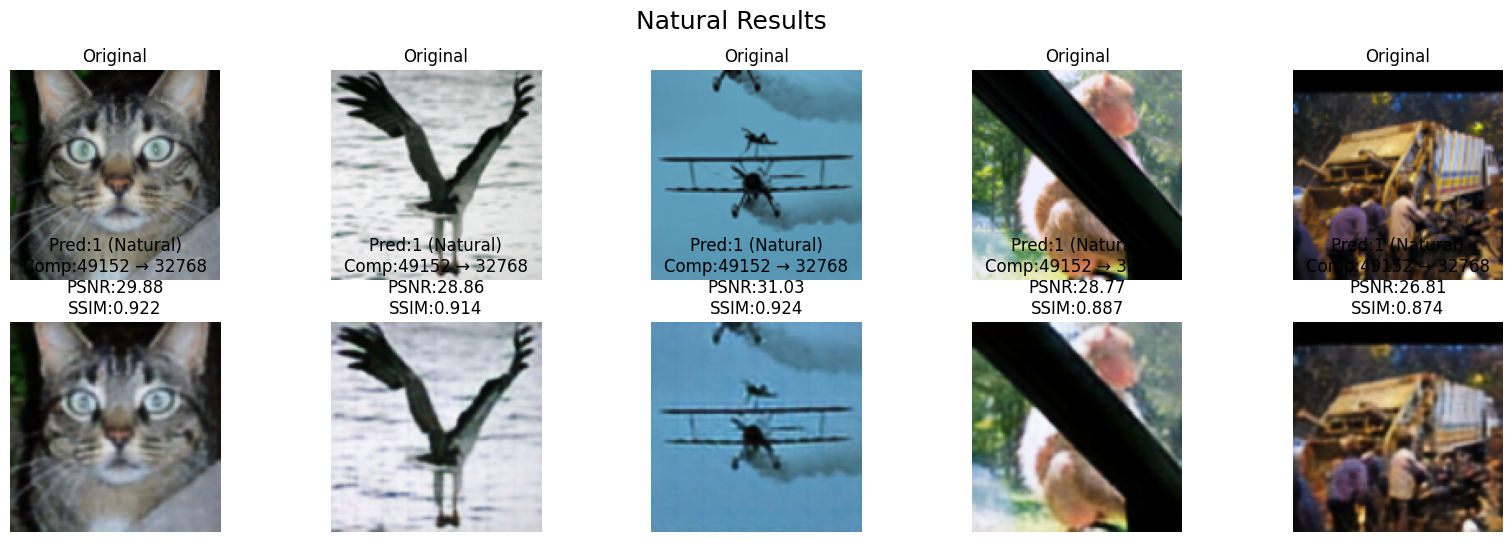

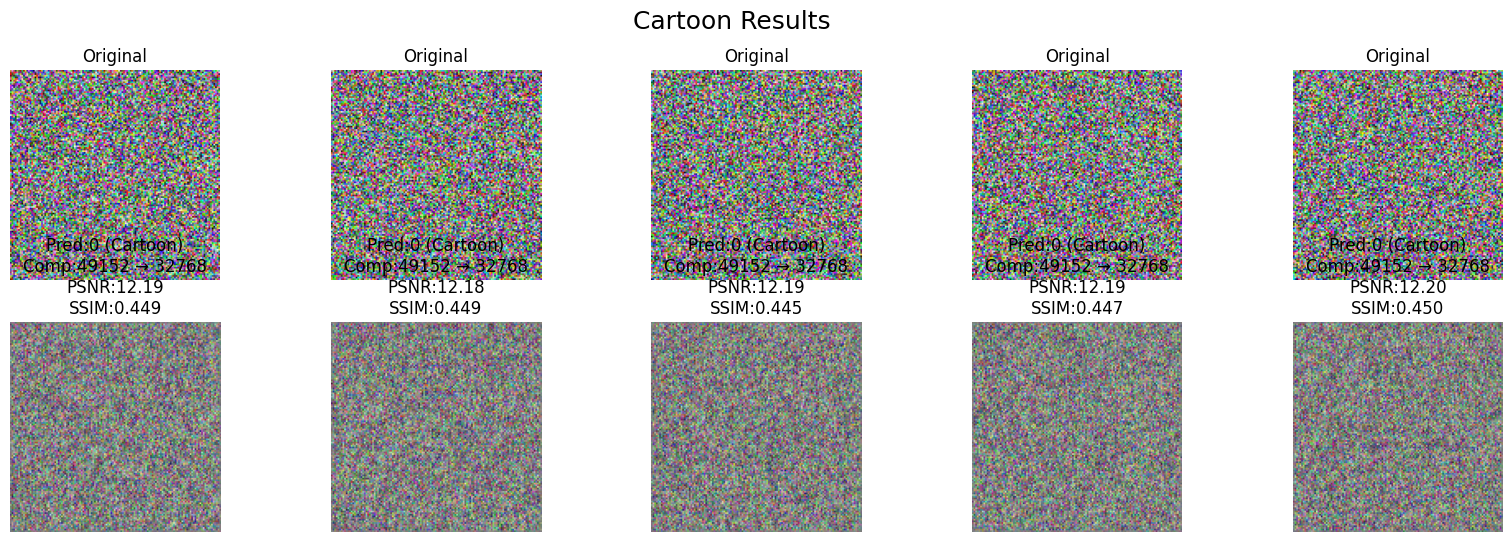

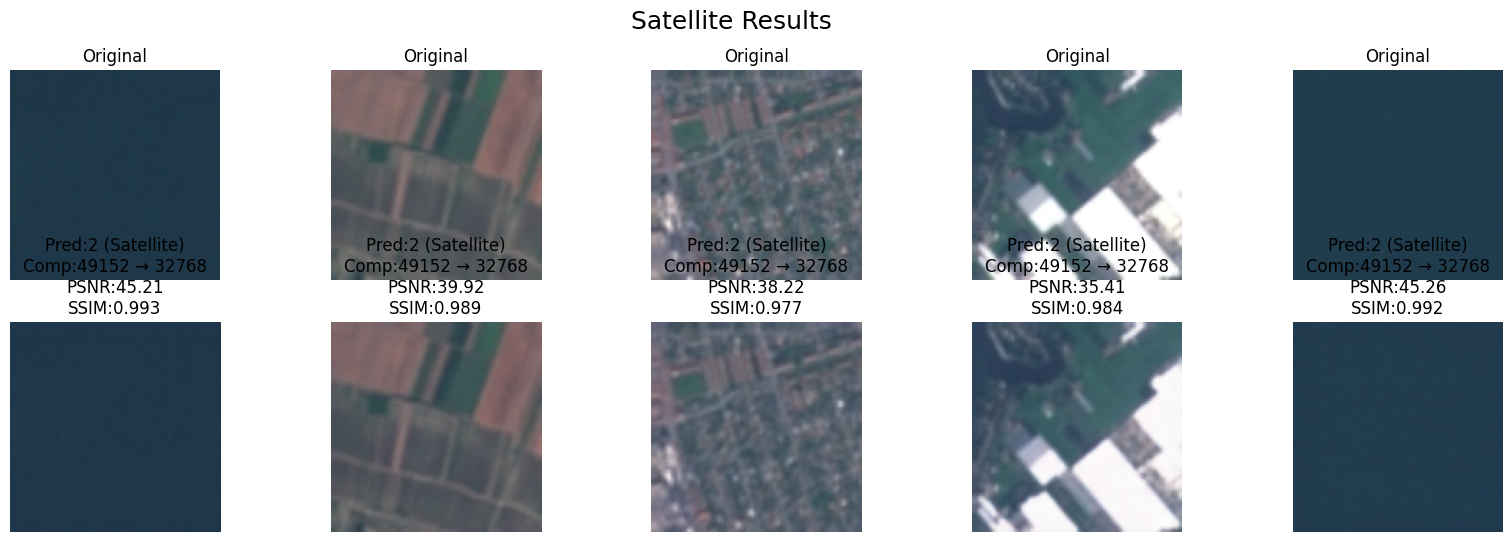

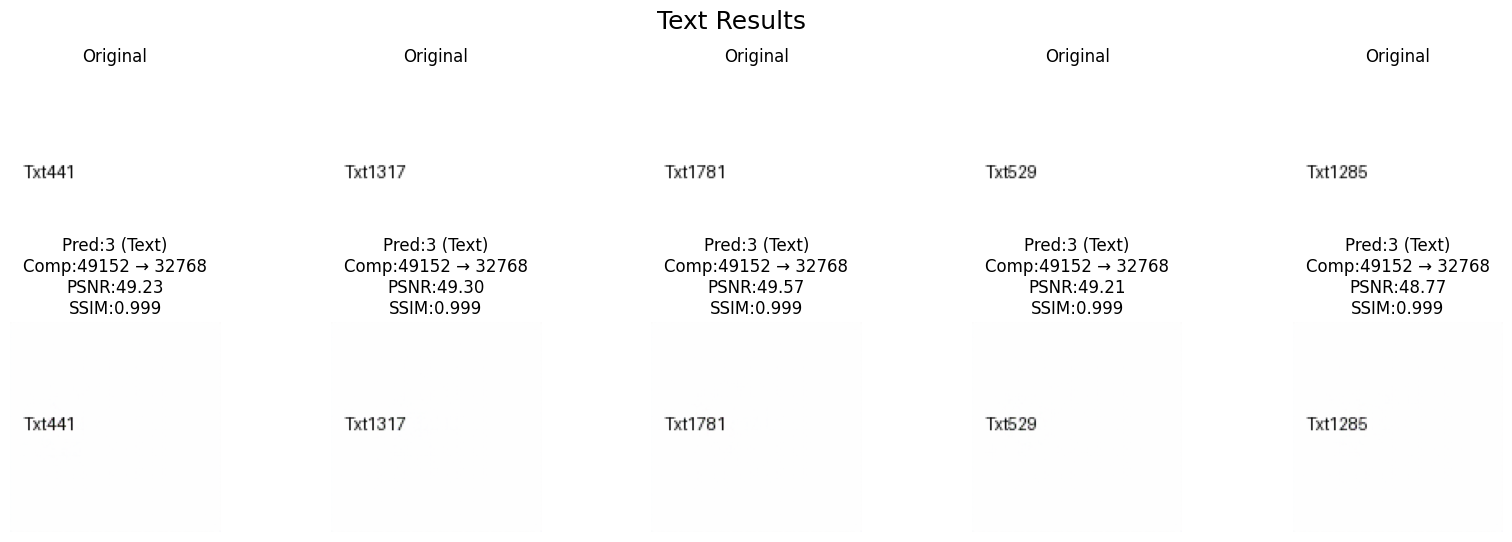

In [23]:
visualize_results(disp_nat, title_prefix="Natural Results")
visualize_results(disp_cartoon, title_prefix="Cartoon Results")
visualize_results(disp_satellite, title_prefix="Satellite Results")
visualize_results(disp_text, title_prefix="Text Results")
